In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This will need to be done in the future so 
# get accustomed to using now
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
mvc = pd.read_csv("nypd_mvc_2018.csv")

In [19]:
data = np.random.choice([1.0, np.nan],
                        size=(3, 3),
                        p=[.3, .7])
df = pd.DataFrame(data, columns=['A','B','C'])
print(df)

     A   B   C
0  1.0 NaN NaN
1  NaN NaN NaN
2  1.0 NaN NaN


In [20]:
print(df.isnull())

       A     B     C
0  False  True  True
1   True  True  True
2  False  True  True


In [21]:
print(df.isnull().sum())

A    1
B    3
C    3
dtype: int64


In [22]:
null_counts = (mvc.isnull().sum())
print(null_counts)

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64


In [23]:
null_counts_pct = null_counts / mvc.shape[0] * 100

In [24]:
null_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})
# Rotate the dataframe so that rows become columns and vice-versa
null_df = null_df.T.astype(int)

print(null_df)

             unique_key  date  time  borough  location  on_street  \
null_counts           0     0     0    20646      3885      13961   
null_pct              0     0     0       35         6         24   

             cross_street  off_street  pedestrians_injured  cyclist_injured  \
null_counts         29249       44093                    0                0   
null_pct               50          76                    0                0   

             ...  vehicle_1  vehicle_2  vehicle_3  vehicle_4  vehicle_5  \
null_counts  ...        355      12262      54352      57158      57681   
null_pct     ...          0         21         93         98         99   

             cause_vehicle_1  cause_vehicle_2  cause_vehicle_3  \
null_counts              175             8692            54134   
null_pct                   0               15               93   

             cause_vehicle_4  cause_vehicle_5  
null_counts            57111            57671  
null_pct                  98     

In [25]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
print(null_df[killed_cols])

             pedestrians_killed  cyclist_killed  motorist_killed  total_killed
null_counts                   0               0                0             5
null_pct                      0               0                0             0


In [26]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum = killed.iloc[:,:3].sum(axis=1)
killed_mask = killed_manual_sum != killed['total_killed']
killed_non_eq = killed[killed_mask]

In [28]:

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

In [29]:
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=['before','after']))

        injured  killed
before        1       5
after        21       0


In [16]:
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']

In [30]:

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

In [31]:
cols_with_missing_vals = mvc.columns[mvc.isnull().sum() > 0]
missing_corr = mvc[cols_with_missing_vals].isnull().corr()
print(missing_corr)

                  borough  location  on_street  cross_street  off_street  \
borough          1.000000  0.190105  -0.350190      0.409107    0.362189   
location         0.190105  1.000000  -0.073975     -0.069719    0.084579   
on_street       -0.350190 -0.073975   1.000000      0.557767   -0.991030   
cross_street     0.409107 -0.069719   0.557767      1.000000   -0.552763   
off_street       0.362189  0.084579  -0.991030     -0.552763    1.000000   
total_injured   -0.003096 -0.001115   0.007372      0.004112   -0.007439   
total_killed    -0.003043 -0.002494   0.007794      0.001757   -0.007902   
vehicle_1       -0.018325 -0.010466  -0.001889     -0.017018    0.001812   
vehicle_2       -0.077516 -0.033842   0.119647      0.043799   -0.121129   
vehicle_3       -0.061932 -0.000927   0.020867     -0.049910   -0.022404   
vehicle_4       -0.020406  0.004655   0.004172     -0.021137   -0.004074   
vehicle_5       -0.010733 -0.005797  -0.002768     -0.012003    0.002492   
cause_vehicl

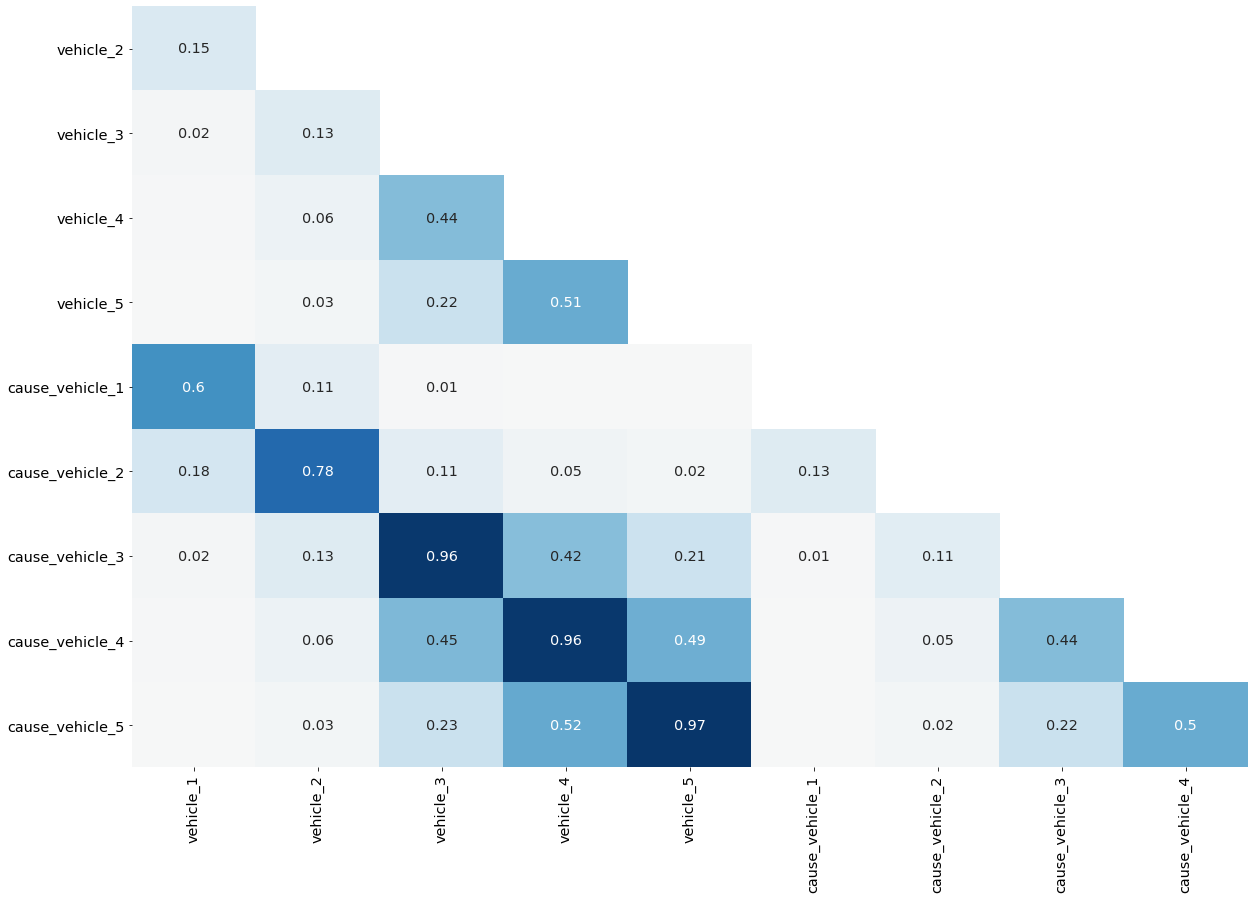

In [32]:
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

#### When a vehicle is in an accident, there is likely to be a cause, and vice-versa.
#### The pairs of column names with higher correlations are:

 - vehicle_1 and cause_vehicle_1
 - vehicle_2 and cause_vehicle_2
 - vehicle_3 and cause_vehicle_3
 - vehicle_4 and cause_vehicle_4
 - vehicle_5 and cause_vehicle_5


In [34]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    # Count the number of rows where vehicle_{} is null and
    # cause_vehicle_{} is not null 
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    
    # do the reverse for cause_vehicle_{} null, vehicle_{} not null
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    # Append item to the vc_null_data list
    vc_null_data.append([v, v_null, c_null])

    # create a dataframe using the vc_null_data list of lists
vc_null_df = pd.DataFrame(vc_null_data, columns=col_labels)

In [35]:
cause_cols = [c for c in mvc.columns if "cause_" in c]
cause = mvc[cause_cols]
print(cause.head())

         cause_vehicle_1      cause_vehicle_2 cause_vehicle_3 cause_vehicle_4  \
0  Following Too Closely          Unspecified             NaN             NaN   
1       Backing Unsafely          Unspecified             NaN             NaN   
2  Following Too Closely          Unspecified             NaN             NaN   
3                  Glare  Passing Too Closely             NaN             NaN   
4     Turning Improperly          Unspecified             NaN             NaN   

  cause_vehicle_5  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  


In [36]:
cause_1d = cause.stack()
print(cause_1d.head())

0  cause_vehicle_1    Following Too Closely
   cause_vehicle_2              Unspecified
1  cause_vehicle_1         Backing Unsafely
   cause_vehicle_2              Unspecified
2  cause_vehicle_1    Following Too Closely
dtype: object


In [37]:
cause_counts = cause_1d.value_counts()
top10_causes = cause_counts.head(10)
print(top10_causes)

Unspecified                       57481
Driver Inattention/Distraction    17650
Following Too Closely              6567
Failure to Yield Right-of-Way      4566
Passing or Lane Usage Improper     3260
Passing Too Closely                3045
Backing Unsafely                   3001
Other Vehicular                    2523
Unsafe Lane Changing               2372
Turning Improperly                 1590
dtype: int64


In [38]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

vehicles = mvc[v_cols]
vehicles_1d = vehicles.stack()
vehicles_counts = vehicles_1d.value_counts()
top10_vehicles = vehicles_counts.head(10)

In [39]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)

    # Count the number of rows where vehicle_{} is null and
    # cause_vehicle_{} is not null 
    v_missing_mask = mvc[v_col].isnull() & mvc[c_col].notnull()
    
    # do the reverse for cause_vehicle_{} null, vehicle_{} not null
    c_missing_mask = mvc[c_col].isnull() & mvc[v_col].notnull()
    
    mvc[v_col] = mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, "Unspecified")

summary_after = summarize_missing()

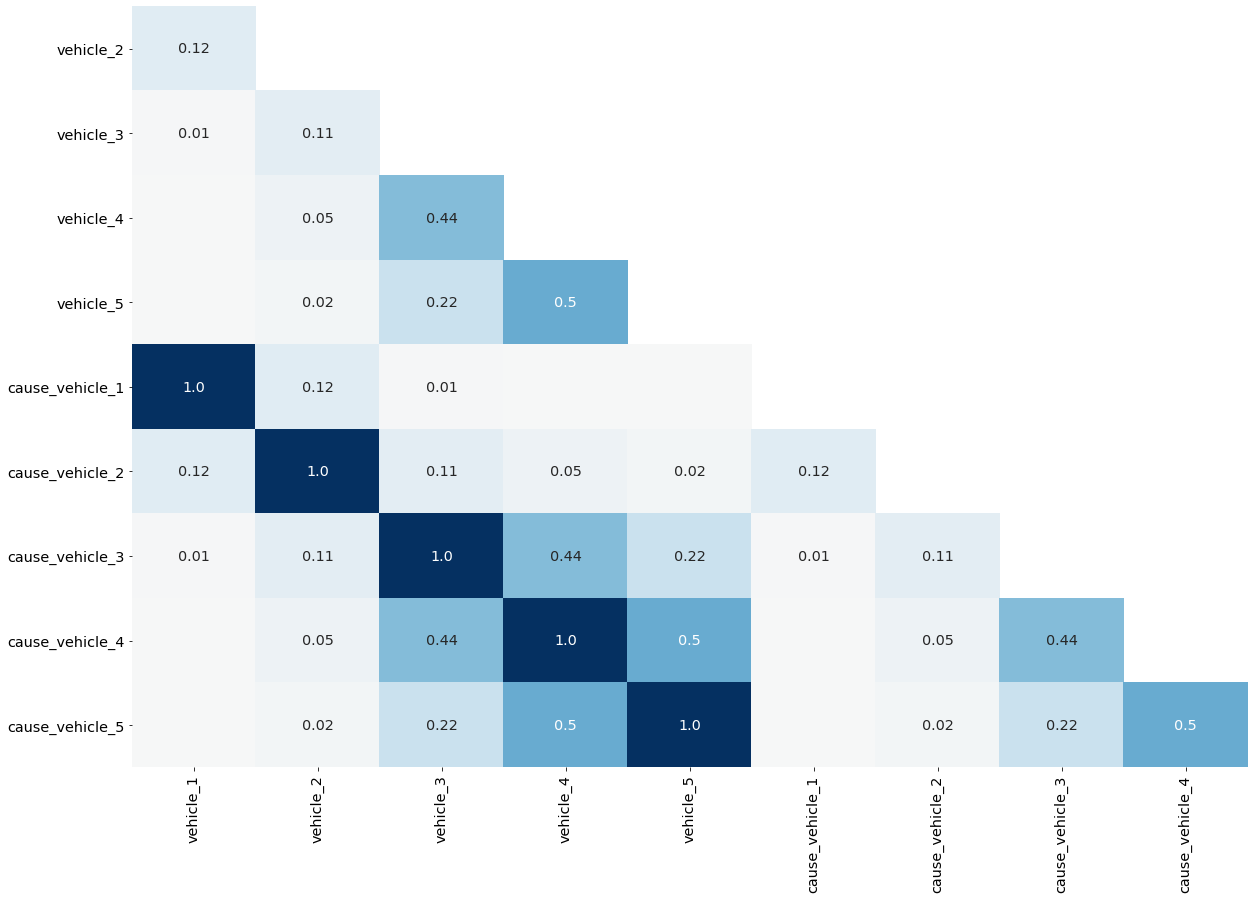

In [40]:
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

In [42]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]

In [43]:
print(location_data.isnull().sum())

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64


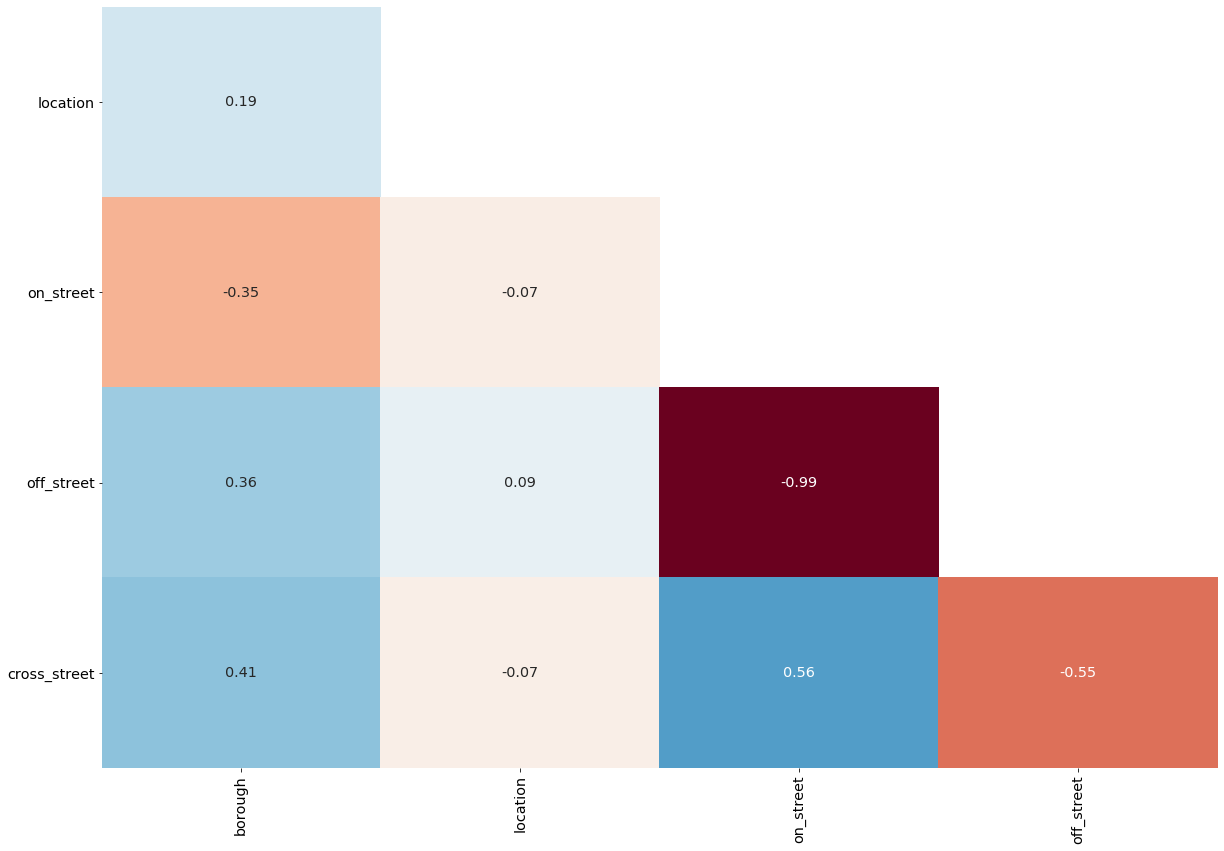

In [44]:
plot_null_correlations(location_data)

In [49]:
sorted_location_data = location_data.sort_values(loc_cols)

# No plot_null_matrix method?? 
# problem with DataQuest - old seaborn version??
plot_null_matrix(sorted_location_data)

NameError: name 'plot_null_matrix' is not defined

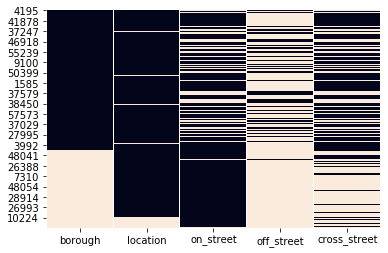

In [48]:
sns.heatmap(sorted_location_data.isnull(), cbar=False)

In [46]:
import missingno as msno

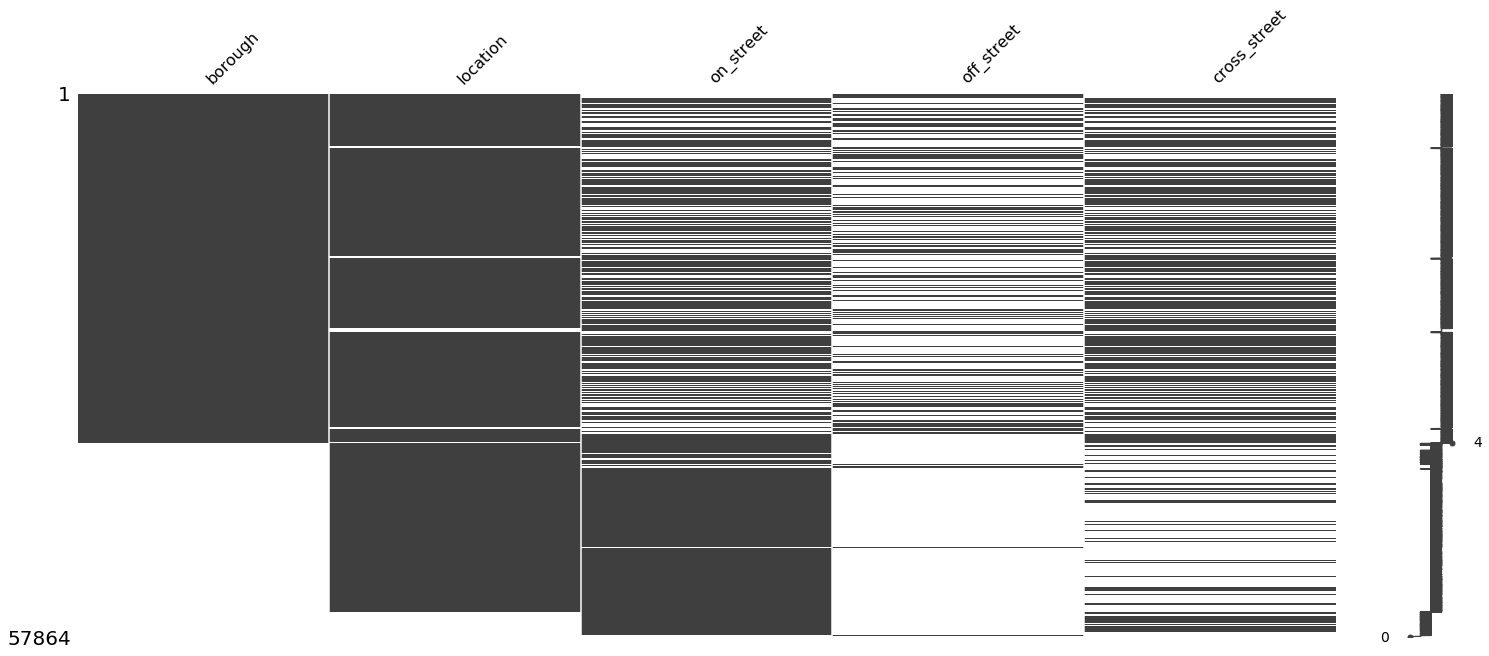

In [47]:
msno.matrix(sorted_location_data)

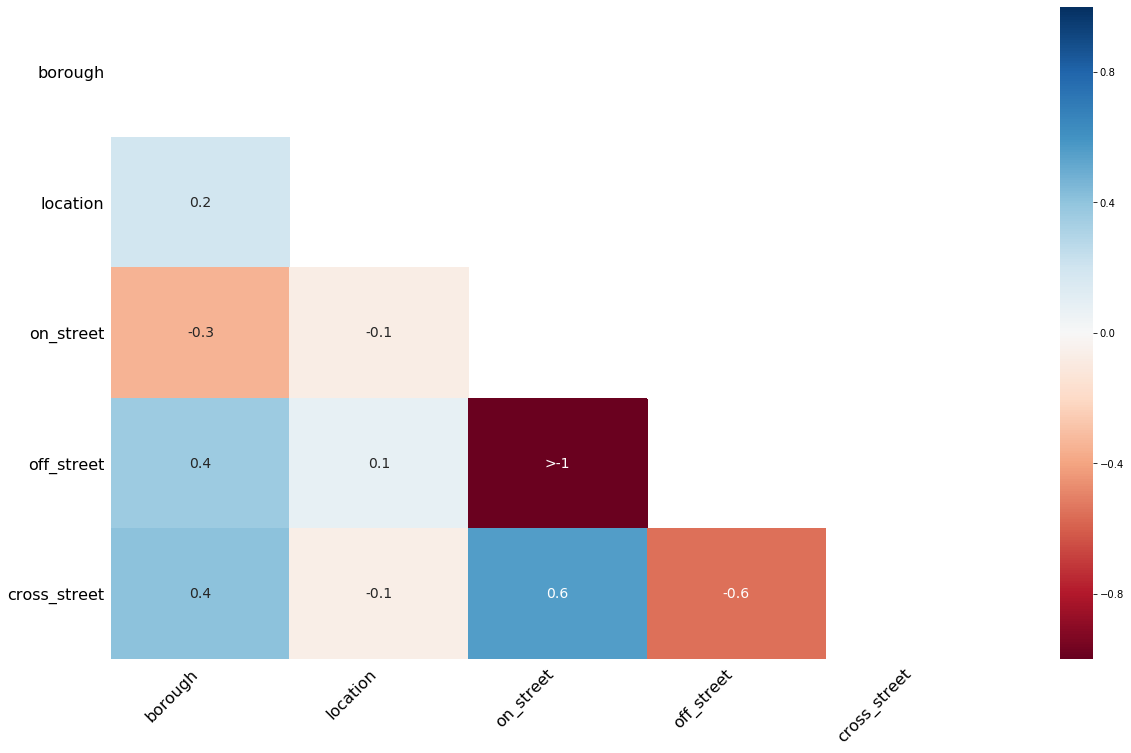

In [50]:
msno.heatmap(sorted_location_data)

In [51]:
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()

for col in location_cols:
    mvc[col] = mvc[col].mask(mvc[col].isnull(), sup_data[col])

null_after = mvc[location_cols].isnull().sum()

If you'd like to continue working with this data, you can:

 - Drop the rows that had suspect values for injured and killed totals.
 - Clean the values in the vehicle_1 through vehicle_5 columns by analyzing the different values and merging duplicates and near-duplicates.
 - Analyze whether collisions are more likely in certain locations, at certain times, or for certain vehicle types.